In [15]:
# !pip install streamlit
# !pip install wordcloud

First 5 rows of the dataset:
shape: (5, 15)
┌──────────────┬────────────┬──────────────────────────┬───────────┬───┬──────┬───────┬─────┬──────┐
│ Unnamed: 0.1 ┆ Unnamed: 0 ┆ Text                     ┆ Sentiment ┆ … ┆ Year ┆ Month ┆ Day ┆ Hour │
│ ---          ┆ ---        ┆ ---                      ┆ ---       ┆   ┆ ---  ┆ ---   ┆ --- ┆ ---  │
│ i64          ┆ i64        ┆ str                      ┆ str       ┆   ┆ i64  ┆ i64   ┆ i64 ┆ i64  │
╞══════════════╪════════════╪══════════════════════════╪═══════════╪═══╪══════╪═══════╪═════╪══════╡
│ 0            ┆ 0          ┆ Enjoying a beautiful day ┆ Positive  ┆ … ┆ 2023 ┆ 1     ┆ 15  ┆ 12   │
│              ┆            ┆ at t…                    ┆           ┆   ┆      ┆       ┆     ┆      │
│ 1            ┆ 1          ┆ Traffic was terrible     ┆ Negative  ┆ … ┆ 2023 ┆ 1     ┆ 15  ┆ 8    │
│              ┆            ┆ this mor…                ┆           ┆   ┆      ┆       ┆     ┆      │
│ 2            ┆ 2          ┆ Just finished an 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


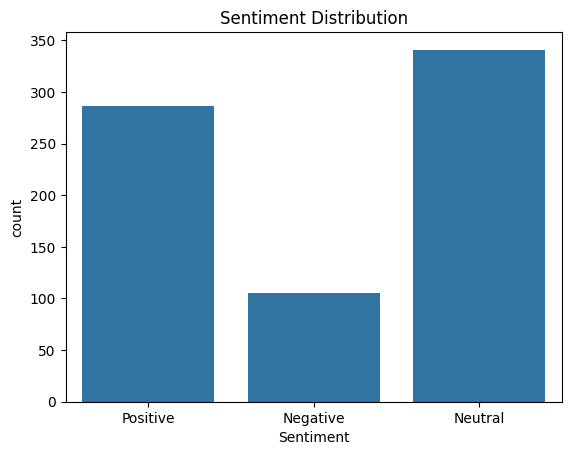


Preprocessed text (first 5 rows):
shape: (5, 1)
┌─────────────────────────────────┐
│ Text                            │
│ ---                             │
│ str                             │
╞═════════════════════════════════╡
│ enjoying beautiful day park     │
│ traffic terrible morning        │
│ finished amazing workout        │
│ excited upcoming weekend getaw… │
│ trying new recipe dinner tonig… │
└─────────────────────────────────┘


In [16]:
import time

start = time.time()

import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

from nltk.corpus import wordnet

nltk.download('stopwords')
nltk.download('wordnet')

wordnet.ensure_loaded()

try:
    df = pl.read_csv('/content/sentimentdataset.csv')
except FileNotFoundError:
    print("Error: 'sentimentdataset.csv' not found.")
    exit()


print("First 5 rows of the dataset:")
print(df.head())

print("\nDataset shape:")
print((df.height, len(df.columns)))
print("\nData types:")
print(df.dtypes)

print("\nSentiment label distribution:")
print(df.select(pl.col("Sentiment")).to_series().value_counts())

sns.countplot(x=df.select("Sentiment").to_series())
plt.title('Sentiment Distribution')
plt.show()

stopwords_set = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub('<[^>]*>', '', text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    tokens = text.split()
    tokens = [word for word in tokens if word not in stopwords_set]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

df = df.with_columns([
    pl.col("Text").map_elements(preprocess_text, return_dtype=pl.Utf8).alias("Text")
])

print("\nPreprocessed text (first 5 rows):")
print(df.select("Text").head())



In [17]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_bow = CountVectorizer()
X_bow = vectorizer_bow.fit_transform(df['Text'])
df_bow = pd.DataFrame(X_bow.toarray(), columns=vectorizer_bow.get_feature_names_out())

vectorizer_tfidf = TfidfVectorizer()
X_tfidf = vectorizer_tfidf.fit_transform(df['Text'])
df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer_tfidf.get_feature_names_out())

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Sentiment'])
X_bow_train, X_bow_test, y_bow_train, y_bow_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)
X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


In [18]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score

In [19]:
models = {
    'Naive Bayes (BoW)': MultinomialNB(),
    'Logistic Regression (BoW)': LogisticRegression(max_iter=1000),
    'SVM (BoW)': SVC(kernel='linear', probability=True),
    'Random Forest (BoW)': RandomForestClassifier(n_jobs=-1),
    'Naive Bayes (TF-IDF)': MultinomialNB(),
    'Logistic Regression (TF-IDF)': LogisticRegression(max_iter=1000),
    'SVM (TF-IDF)': SVC(kernel='linear', probability=True),
    'Random Forest (TF-IDF)': RandomForestClassifier(n_jobs=-1)
}

In [20]:
results = {}

for name, model in models.items():
    if 'BoW' in name:
        model.fit(X_bow_train, y_bow_train)
        y_pred = model.predict(X_bow_test)
    else:
        model.fit(X_tfidf_train, y_tfidf_train)
        y_pred = model.predict(X_tfidf_test)

    f1_macro = f1_score(y_bow_test if 'BoW' in name else y_tfidf_test, y_pred, average='macro')
    results[name] = f1_macro
    print(f"{name} - Macro-average F1 Score: {f1_macro:.4f}")

Naive Bayes (BoW) - Macro-average F1 Score: 0.6404
Logistic Regression (BoW) - Macro-average F1 Score: 0.6020
SVM (BoW) - Macro-average F1 Score: 0.6735
Random Forest (BoW) - Macro-average F1 Score: 0.5808
Naive Bayes (TF-IDF) - Macro-average F1 Score: 0.4600
Logistic Regression (TF-IDF) - Macro-average F1 Score: 0.4549
SVM (TF-IDF) - Macro-average F1 Score: 0.5221
Random Forest (TF-IDF) - Macro-average F1 Score: 0.5274


In [21]:
import joblib

try:
    if 'best_model' not in globals():
        best_model_name = max(results, key=results.get)
        best_model = models[best_model_name]
        print(f"Best model selected: {best_model_name}")

    if 'BoW' in best_model_name:
        joblib.dump((best_model, vectorizer_bow, label_encoder), 'sentiment_model_bow.joblib')
        print("✅ Best model saved as 'sentiment_model_bow.joblib'")
    else:
        joblib.dump((best_model, vectorizer_tfidf, label_encoder), 'sentiment_model_tfidf.joblib')
        print("✅ Best model saved as 'sentiment_model_tfidf.joblib'")
except Exception as e:
    print(f"❌ Error during saving the model: {e}")


✅ Best model saved as 'sentiment_model_bow.joblib'


In [22]:
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

print(f"\nBest Model: {best_model_name}")


Best Model: SVM (BoW)


In [23]:
if 'BoW' in best_model_name:
    joblib.dump((best_model, vectorizer_bow, label_encoder), 'sentiment_model_bow.joblib')
else:
    joblib.dump((best_model, vectorizer_tfidf, label_encoder), 'sentiment_model_tfidf.joblib')

print("\nBest model saved as 'sentiment_model_bow.joblib' or 'sentiment_model_tfidf.joblib'")


Best model saved as 'sentiment_model_bow.joblib' or 'sentiment_model_tfidf.joblib'


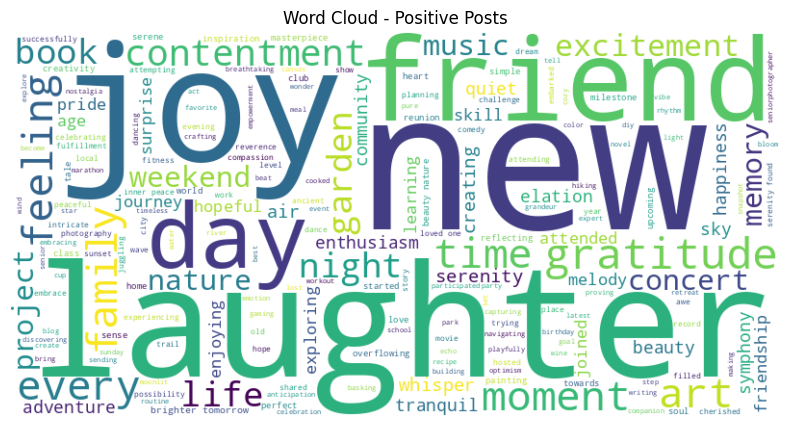

In [24]:
from wordcloud import WordCloud

# Positive
filtered = df.filter(pl.col("Sentiment") == "Positive")
text_data = ' '.join(filtered.select("Text").to_series())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud - Positive Posts")
plt.axis('off')
plt.show()


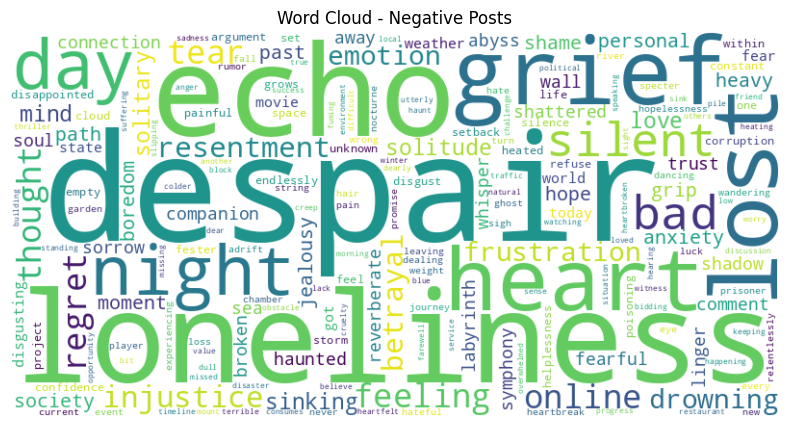

In [25]:
# Negative
filtered = df.filter(pl.col("Sentiment") == "Negative")
text_data = ' '.join(filtered.select("Text").to_series())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud - Negative Posts")
plt.axis('off')
plt.show()


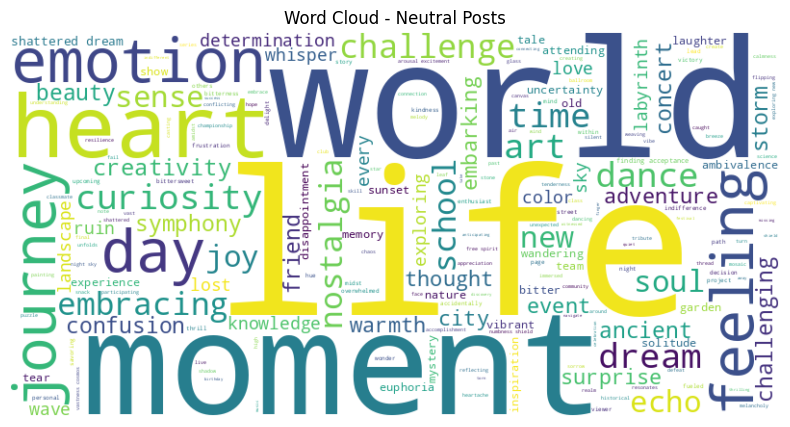

In [26]:
# Neutral
filtered = df.filter(pl.col("Sentiment") == "Neutral")
text_data = ' '.join(filtered.select("Text").to_series())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud - Neutral Posts")
plt.axis('off')
plt.show()


In [27]:
end = time.time()
print(f"\nExecution time: {end - start:.2f} seconds")


Execution time: 4.15 seconds


In [28]:
#!streamlit run app_sentiment.py